# Collaboration and Competition

Run this notebook end-to-end to complete Project 3 - Collaboration and Competition of Udacity's Deep Reinforcement Learning Nanodegree program.


### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


Import all python packages needed to execute the notebook.

In [2]:
!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1554    0     0   8816      0 --:--:-- --:--:-- --:--:--  8982


In [3]:
from collections import namedtuple, deque
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unityagents import UnityEnvironment
from workspace_utils import active_session

The environment is already saved in the Workspace and can be accessed at the file path provided below. However, if running this notebook locally, or using the single-arm environment, change `PATH_TO_ENV` to the appropriate file path.

In [4]:
PATH_TO_ENV = "/data/Tennis_Linux_NoVis/Tennis"
env = UnityEnvironment(file_name=PATH_TO_ENV)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


**ASIDE**: Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

print(f"brain name: {brain_name}\nbrain type: {type(brain)}")

brain name: TennisBrain
brain type: <class 'unityagents.brain.BrainParameters'>


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

**NOTE:** A majority of DDPG boilerplate code was recycled from the DDPG exercise, and refactored to support Multi-agent collaboration / learning.

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

First, lets determine which device we are using. This will changed whether running this notebook on CPU or GPU hardware.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

The algorithm being used is the **Deep Deterministic Policy Gradient (DDPG)**. The algorithm learns both a policy and a value function at the same time through the use of an Actor (the policy) and a Critic (the value function estimator). DDPG is often considered Deep Q-Learning but when the action space is continuous, as it is for the environment we are trying to solve.

The one alteration being made for this implementation in relation to the implementation for project 2 is that this is a multi-agent environment. The state space will contain both of the player's observations spaces concatenated to each other. The Agent will learn the best actions for each player and will return these actions when interacting with the environment.

Next, we need to set the value for all of the hyperparameters used during learning.

In [9]:
# replay buffer and sample hyperparameters
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size

# agent learning parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
LEARN_EVERY = 1         # learning timestep interval
LEARN_NUM = 5           # number of learning passes
GAMMA = 0.99            # discount factor
TAU = 8e-3              # for soft update of target parameters

# noise parameters
OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion

# epsilon decay hyperparameters
EPS_START = 5.0         # initial value for epsilon in noise decay process in Agent.act()
EPS_EP_END = 300        # episode to end the noise decay process
EPS_FINAL = 0           # final value for epsilon after decay

# training loop hyperparameters
N_EPISODES = 5000       # number of episodes
MAX_T = 2000            # maximum number of timesteps per episode

The models we are using for the Actor and Critic are fully connected dense networks, with a batch normalization layer just after the input layer to normalize across the minibatches that are fed forward through the networks. The activation layer at the output of the Actor is a Tanh function to surpress the possible continuous actions to (-1, 1).

There is no activation layer at the output of the Critic as we want to Critic to be learning the value of each state-action pair.

In [10]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))
    
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*2, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+(action_size*2), fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

The Agent contains both a local and target version of the Actor and Critic, which helps to stablize learning. We add Ornstein-Uhlenbeck noise to the action process to simulate the same type of exploration-exploitation behavior in traditional DQN, with this noise factor decaying over time.

The Agent contains a Replay Buffer where we store experiences to sample from during learning. As the Agent interacts with the environment, experiences are added to the buffer for later use. The older experiences will fall out of the buffer as new ones are added.

In order to promote smooth learning, we include a soft update of the target network parameters from the local networks parameters for both the Actor and the Critic. This insures we don't take too large of steps in the learning process. We can also control learning by performing `n` forward and back prop passes every `m` timesteps.

In [11]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(1)
        self.state = x + dx
        return self.state

In [12]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [13]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise((1, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done, agent_id):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA, agent_id)

    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((1, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            # concatenate agent's action
            for id, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[id, :] = action
        self.actor_local.train()
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, agent_id):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        
        # get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        
        # concatenate actions_next based on agent's id
        if agent_id == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
        
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # compute actor loss
        actions_pred = self.actor_local(states)
        
        # concatenate actions_pred based on agent's id
        if agent_id == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)
        
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


Lets initialize the Agent for both players and print the network architecture for the Actor and Critic.

In [14]:
agent_a = Agent(state_size, action_size, random_seed=0)
agent_b = Agent(state_size, action_size, random_seed=0)

for agent_id, agent in [("A", agent_a), ("B", agent_b)]:
    print(f"--- Agent {agent_id} ---")
    print("  actor architecture")
    print(agent.actor_local)

    print("  critic architecture")
    print(agent.critic_local)

--- Agent A ---
  actor architecture
Actor(
  (fc1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
  critic architecture
Critic(
  (fcs1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=260, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
--- Agent B ---
  actor architecture
Actor(
  (fc1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
  critic architecture
Critic(
  (fcs1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=260, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


The DDPG training algorithm is defined in the function below. This is where the Agents interact with the environment, saves experience, and perform learning.

The function prints out status messages showing the progress of learning, and completes once the environment has been considered solved (average score of 0.50 over the previous 100 episodes)

In [15]:
def maddpg(n_episodes=5000, max_t=1000, print_every=100, solved_score=0.5):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        print_every (int)     : interval to display results
        solved_score (int)    : environment to considered solved
    """
    
    scores_window = deque(maxlen=100)  # running deque of 100 most recent scores
    scores_all = []                    # list of all scores
    scores_avg = []                    # list of average scores
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment
        states = np.reshape(env_info.vector_observations, (1, 48)) # get states and concatenate
        agent_a.reset()                                            # reset agent a
        agent_b.reset()                                            # reset agent b
        scores = np.zeros(num_agents)                              # initialize scores
        
        for t in range(max_t):
            
            action_a = agent_a.act(states)                                   # take action for agent a
            action_b = agent_b.act(states)                                   # take action for agent b
            actions = np.concatenate((action_a, action_b), axis=0).flatten() # concatenate agent actions
            
            env_info = env.step(actions)[brain_name]                         # send actions to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48))  # get next states
            rewards = env_info.rewards                                       # get rewards
            done = env_info.local_done                                       # get done flags
            
            agent_a.step(states, actions, rewards[0], next_states, done, 0)  # take learning step for agent a
            agent_b.step(states, actions, rewards[1], next_states, done, 1)  # take learning step for agent b
            
            states = next_states                                             # prepare for next iteration
            scores += np.max(rewards)                                        # update running scores
            
            if np.any(done):                                                 # exit loop when episode ends
                break 
        
        # track scores
        max_score = np.max(scores)
        scores_window.append(max_score)
        scores_all.append(max_score)
        average_score = np.mean(scores_window)
        scores_avg.append(average_score)
                
        if i_episode % print_every == 0:
            _as = round(average_score, 2)
            _ms = round(np.max(scores_all[-print_every:]), 3)
            print(f'\repisode {i_episode}\tavg score: {_as}\tmax score: {_ms}')
            
        if average_score > solved_score:
            _as = round(average_score, 2)
            print(f'\nEnvironment succesfully solved in {i_episode} episodes!\tAverage Score: {_as}')
            break
                
    return scores_all

In [16]:
t0 = time.time()
 
with active_session():
    scores = maddpg(n_episodes=N_EPISODES, max_t=MAX_T)

t1 = time.time()
elapsed = (t1 - t0) / 60.0
print(f"\nTotal training time: {round(elapsed, 4)} minutes")

episode 100	avg score: 0.0	max score: 0.1
episode 200	avg score: 0.01	max score: 0.4
episode 300	avg score: 0.03	max score: 0.1
episode 400	avg score: 0.03	max score: 0.2
episode 500	avg score: 0.04	max score: 0.2
episode 600	avg score: 0.06	max score: 0.5
episode 700	avg score: 0.08	max score: 0.4
episode 800	avg score: 0.12	max score: 0.6
episode 900	avg score: 0.15	max score: 0.7
episode 1000	avg score: 0.27	max score: 1.8
episode 1100	avg score: 0.29	max score: 1.9
episode 1200	avg score: 0.28	max score: 1.2
episode 1300	avg score: 0.37	max score: 2.3
episode 1400	avg score: 0.21	max score: 1.1
episode 1500	avg score: 0.21	max score: 1.0
episode 1600	avg score: 0.3	max score: 2.0
episode 1700	avg score: 0.46	max score: 1.9
episode 1800	avg score: 0.36	max score: 2.7
episode 1900	avg score: 0.45	max score: 2.0
episode 2000	avg score: 0.45	max score: 2.0

Environment succesfully solved in 2038 episodes!	Average Score: 0.51

Total training time: 43.6243 minutes


When finished training, you can close the environment.

In [17]:
env.close()

### 5. Visualizing results and saving best model

Below we can see the model scores for each episode combined with the 100 episode moving average. The moving average trend is useful to show the overall progress of learning when individual episodes may appear noisy.

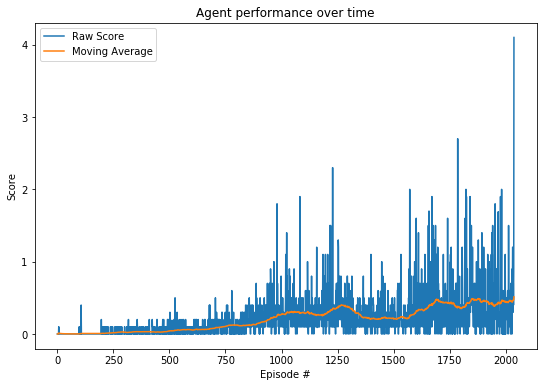

In [18]:
# plot the scores
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label="Raw Score")

# plot the moving average
scores_series = pd.Series(scores)
windows = scores_series.rolling(100, min_periods=1)
ma = windows.mean().dropna()
x, y = ma.index, ma.values
plt.plot(x, y, label="Moving Average")

plt.xlabel("Episode #")
plt.ylabel("Score")
plt.title("Agent performance over time")
plt.legend()

fig.savefig("performance.png")

In [19]:
# save model
torch.save(agent_a.actor_local.state_dict(), 'checkpoints/checkpoint_actor_a.pth')
torch.save(agent_a.critic_local.state_dict(), 'checkpoints/checkpoint_critic_a.pth')
torch.save(agent_b.actor_local.state_dict(), 'checkpoints/checkpoint_actor_b.pth')
torch.save(agent_b.critic_local.state_dict(), 'checkpoints/checkpoint_critic_b.pth')

### 6. Potential Improvements

Some additional ideas that could lead to better performance or interesting insights include:

* Different model architectures (more/less layers, larger/smaller layer sizes)
* Prioritized replay buffer
* Different policy gradient algorithms like A3C or SAC
* Training each agent only on their observation space (not concatenating the two / imperfect information)